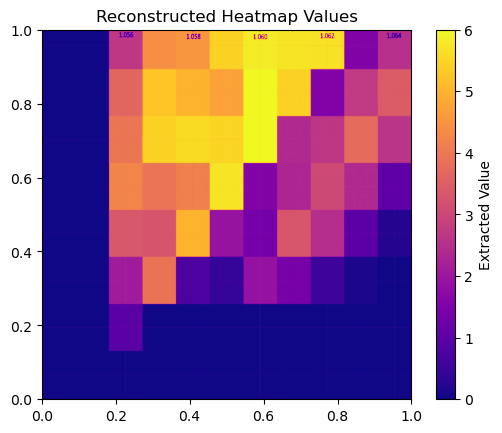

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor

# === CONFIGURATION ===
heatmap_path = 'heatmap_copy.png'  # Replace with your PNG file path
colorbar_coords = (1127, 12, 1136, 918)  # Replace with bounding box of colorbar (left, top, right, bottom)
heatmap_coords = (79, 6, 1105, 854)   # Replace with bounding box of actual heatmap area

value_range = (0, 6)       # Replace with min and max of the colorbar scale
orientation = 'vertical'           # or 'horizontal'

# === STEP 1: Load Image ===
img = cv2.imread(heatmap_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# === STEP 2: Extract Colorbar and Build Mapping ===
x1, y1, x2, y2 = colorbar_coords
colorbar = img_rgb[y1:y2, x1:x2]

if orientation == 'vertical':
    color_samples = colorbar[:, colorbar.shape[1] // 2]
    values = np.linspace(value_range[1], value_range[0], len(color_samples))  # top to bottom
else:
    color_samples = colorbar[colorbar.shape[0] // 2, :]
    values = np.linspace(value_range[0], value_range[1], len(color_samples))  # left to right

# Build RGB → Value model using KNN
X_color = color_samples.reshape(-1, 3)
y_value = values
knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(X_color, y_value)

# === STEP 3: Extract Heatmap Area ===
hx1, hy1, hx2, hy2 = heatmap_coords
heatmap_region = img_rgb[hy1:hy2, hx1:hx2]

# === STEP 4: Map Each Pixel to Value ===
heatmap_reshaped = heatmap_region.reshape(-1, 3)
predicted_values = knn.predict(heatmap_reshaped)
heatmap_values = predicted_values.reshape(heatmap_region.shape[:2])

# === STEP 5: Show the Reconstructed Data ===
plt.imshow(heatmap_values, extent=[0, 1, 0, 1], cmap='plasma')
plt.colorbar(label='Extracted Value')
plt.title("Reconstructed Heatmap Values")
plt.show()


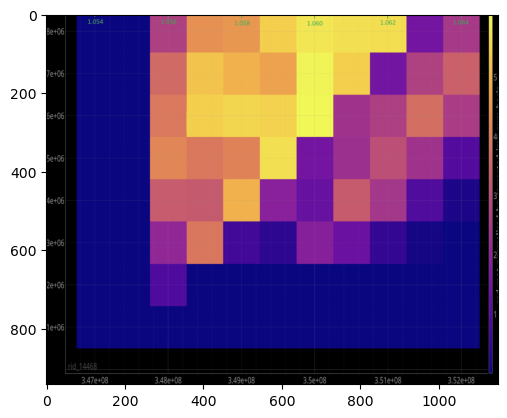

In [2]:
plt.imshow(img_rgb)

# 250504 Now plot nice plot

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import re
from scipy.optimize import curve_fit
from scipy import ndimage
import pickle

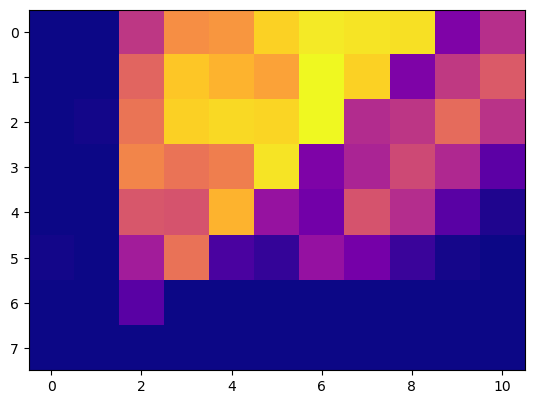

In [4]:
data = [[0.04, 0.04, 2.70, 4.42, 4.55, 5.46, 5.81, 5.71, 5.68, 1.56, 2.53],
        [0.04, 0.03, 3.64, 5.30, 5.01, 4.73, 6.00, 5.46, 1.54, 2.74, 3.42],
        [0.04, 0.09, 3.95, 5.44, 5.57, 5.51, 6.01, 2.46, 2.67, 3.75, 2.60],
        [0.03, 0.03, 4.24, 3.92, 4.12, 5.71, 1.54, 2.31, 3.08, 2.39, 1.03],
        [0.04, 0.04, 3.35, 3.28, 5.01, 1.94, 1.35, 3.30, 2.50, 0.98, 0.21],
        [0.09, 0.04, 2.15, 3.90, 0.76, 0.46, 1.90, 1.39, 0.54, 0.12, 0.03],
        [0.04, 0.03, 0.97, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03],
        [0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03]]

data = np.array(data)

plt.imshow(data, cmap='plasma')

In [5]:
# copy paste this code to the beginning of your script to set the plotting style for a one column figure

from matplotlib import pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "figure.constrained_layout.use": True
})

plt.rcParams["savefig.bbox"] = None
plt.rcParams["figure.figsize"] = (5.9,5)  # (width, height) in inches, change height but not width
plt.rcParams["figure.titlesize"] = 10 # this is only for plt.suptitle, i set it to be the same as the rest

plt.rcParams["axes.titlesize"] = 10 # control title size
plt.rcParams["axes.labelsize"] = 10 # control x and y axis labels
plt.rcParams["axes.labelpad"] = 4.0 # distance between axis label and axis numbers
plt.rcParams["xtick.labelsize"] = 10 # independent control of xlabel fontsize
plt.rcParams["ytick.labelsize"] = 10 # independent control of ylabel fontsize

plt.rcParams["legend.fontsize"] = 7.5 # control legend size, I set it to be slightly smaller than title/axes label
# plt.rcParams["legend.facecolor"] = (0.9, 0.9, 0.9) # legend background color
# plt.rcParams["legend.edgecolor"] = (0, 0, 0) # legend border line color
# plt.rcParams["legend.frameon"] = True # whether or not to draw a border around legend
# plt.rcParams["legend.framealpha"] = 0.1 # legend background transparency
plt.rcParams["legend.loc"] = "best" # default legend location
plt.rcParams["legend.handletextpad"] = 0.8  # Horizontal space between legend point and text (default 0.8)
plt.rcParams["legend.labelspacing"] = 0.6  # Vertical space between legend entries (default 0.5)
# plt.rcParams["legend.columnspacing"] = 2.0  # Space between columns in multi-column legends
# plt.rcParams["legend.borderpad"] = 1.0  # Space between legend content and the box
# plt.rcParams["legend.handlelength"] = 2.0  # Length of legend marker lines

plt.rcParams["lines.linewidth"] = 1
plt.rcParams["lines.markersize"] = 6 #data point size

# CHOOSE NICE COLOR FOR DARK MARKER EDGEWIDTH FROM "dodgerblue","mediumseagreen","crimson","mediumpurple","slateblue","darkorange","peru","goldenrod"
# plt.rcParams["lines.linewidth"] = 1
# plt.rcParams["lines.markersize"] = 6 #data point size
# plt.rcParams["lines.markeredgewidth"] = 1.5 # width of the edge of the marker
# plt.rcParams["lines.markeredgecolor"] = "black" # color of the edge of the marker
# plt.rcParams["lines.markerfacecolor"] = "dodgerblue" # color of the inside of the marker
# plt.rcParams["lines.marker"] = "o" # marker type, see https://matplotlib.org/stable/api/markers_api.html for all options
# plt.rcParams["lines.color"] = "black" # color of the line
# # CHOOSE NICE COLOR FOR DARK MARKER EDGEWIDTH FROM "dodgerblue","mediumseagreen","crimson","mediumpurple","slateblue","darkorange","peru","goldenrod"


plt.rcParams["grid.linestyle"] = "--"
plt.rcParams['axes.grid'] = False
# plt.rcParams["grid.linewidth"] = 0.7

# plt.rcParams["xtick.major.pad"] = 4.0 # distance between xticks dashes and xaxis numbers
# plt.rcParams["xtick.major.size"] = 3.0
# plt.rcParams["xtick.major.width"] = 0.7
# plt.rcParams["ytick.major.pad"] = 4.0 # distance between yticks dashes and yaxis numbers
# plt.rcParams["ytick.major.size"] = 3.0
# plt.rcParams["ytick.major.width"] = 0.7

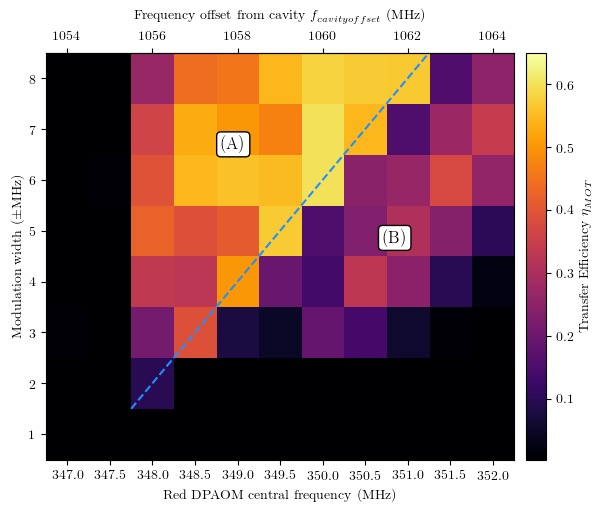

In [56]:
data = [[0.04, 0.04, 2.70, 4.42, 4.55, 5.46, 5.81, 5.71, 5.68, 1.56, 2.53],
        [0.04, 0.03, 3.64, 5.30, 5.01, 4.73, 6.00, 5.46, 1.54, 2.74, 3.42],
        [0.04, 0.09, 3.95, 5.44, 5.57, 5.51, 6.01, 2.46, 2.67, 3.75, 2.60],
        [0.03, 0.03, 4.24, 3.92, 4.12, 5.71, 1.54, 2.31, 3.08, 2.39, 1.03],
        [0.04, 0.04, 3.35, 3.28, 5.01, 1.94, 1.35, 3.30, 2.50, 0.98, 0.21],
        [0.09, 0.04, 2.15, 3.90, 0.76, 0.46, 1.90, 1.39, 0.54, 0.12, 0.03],
        [0.04, 0.03, 0.97, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03],
        [0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03]]

data = np.array(data)/10

freq_axis = np.linspace(347.0, 352.0, 11)
modwidth_axis = np.linspace(1,8,8)

fig, ax = plt.subplots()

plt.imshow(data, cmap='inferno', aspect='auto', vmax=0.65, extent=[freq_axis[0]-0.25, freq_axis[-1]+0.25, modwidth_axis[0]-0.5, modwidth_axis[-1]+0.5])

# Define the transformation functions for the secondary x-axis
def freq_to_offset(x):
    return x * 2 + 460 - 100 
def offset_to_freq(x):
    return (x + 100 - 460) / 2
# Apply the transformation functions for the secondary axis
ax_top = ax.secondary_xaxis('top', functions=(freq_to_offset, offset_to_freq))
ax_top.set_xlabel(r'Frequency offset from cavity $f_{cavityoffset}$ (MHz)', labelpad=8)

# Set custom tick positions for x and y axes to ensure proper alignment
ax.set_xticks(np.linspace(freq_axis[0], freq_axis[-1], 11))
ax.set_yticks(np.linspace(modwidth_axis[0], modwidth_axis[-1], 8))

plt.colorbar(label=r'Transfer Efficiency $\eta_{MOT}$', pad=0.025)
plt.xlabel('Red DPAOM central frequency (MHz)')
plt.ylabel(r'Modulation width ($\pm$MHz)')

ax.plot([347.75, 351.25], [1.5, 8.5], ls='--', color='dodgerblue', lw=1.5, zorder=10)
# ax.plot([346.75, 352.25], [5, 5], ls='--', color='mediumpurple', lw=1.5, zorder=5, alpha=0.5)

ax.text(
    0.4, 0.775, " (A)",
    transform=ax.transAxes,
    fontsize=12,
    fontweight='bold',
    va='center',
    ha='center',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.25')
)

ax.text(
    0.745, 0.545, " (B)",
    transform=ax.transAxes,
    fontsize=12,
    fontweight='bold',
    va='center',
    ha='center',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.25')
)

plt.savefig('250504 BBRedMOT2DScanFreqModWidthResultsPlot.pdf', dpi=300)